___One of the more important aspects of AB testing is explainability to stake-holders. How do you interpret your results? In order to do so, it is necessary to have a fundamental grasp of how the algorithm works.___

Taking the example from last notebook,

In [188]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import scipy.stats as stats

random.seed(30)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (12.5, 9),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

__Generate Data:__

In [189]:
def generate_data(sample_number):
    revenue_per_user_range = np.arange(50, 100, 0.012)
    #Note THIS IS NOT the Randomization unit. I am just assigning 1000 'users' with random revenue-per-user quantities from the above list
    control = random.choices(revenue_per_user_range, k=sample_number)
    treatment = random.choices(revenue_per_user_range, k=sample_number)
    return control,treatment

control,treatment  = generate_data(1000)

## Simple EDA

Doing some plots is always an easy way to visually get an idea of how the experiment went (specially when you have a larger number of variants. First we start with a KDE plot which is Kernel Density Plot(probability Density of a continuous variable).

__Note__: _While kernel density estimation produces a probability distribution, the height of the curve at each point gives a density, not a probability. A probability can be obtained only by integrating the density across a range._

We are also going to do a box plot as well as swarm plot to see the observations of the data. 

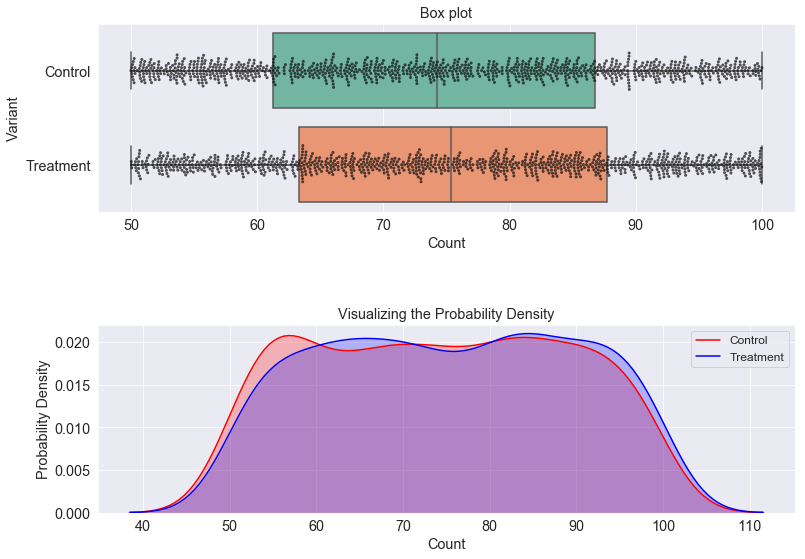

In [190]:
f, (ax1, ax2) = plt.subplots(2, 1)
plt.subplots_adjust(hspace=0.6)

sns.boxplot(data=[control,treatment], orient="h", palette="Set2", ax=ax1)
sns.swarmplot(data=[control,treatment],orient="h", color=".05", size=3, alpha=0.7, ax=ax1)

#sns.catplot(data=[control,treatment],orient="h",  ax=ax1)
ax1.set_yticklabels(['Control','Treatment'])
ax1.set_ylabel('Variant')
ax1.set_xlabel('Count')
ax1.set_title('Box plot')

sns.kdeplot(data=control, color='r', shade=True, label = 'Control', ax=ax2)
sns.kdeplot(data=treatment, color='b', shade=True, label = 'Treatment', ax=ax2)
ax2.set_ylabel('Probability Density')
ax2.set_xlabel('Count')
plt.title('Visualizing the Probability Density')
plt.legend()

In Hypothesis testing, plots definitely help us give a bigger picture of the experiment. However, statistical testing is essential in assisting with decision-making.

***

# T-test


One of the most common methods of calculating significance in Controlled Online Experiments is __T-test__.

To reiterate from the previous chapter, T-test compares the mean of two difference samples with consideration to the variance of them, ultimately giving the significance of how different they are from each other. Welch's T-test differs from Student's T-test in the assumption of variances. Student's t-test assumes that the variance is the same for both the sample whereas Welch's T-test assumes unequal variances. Here we focus on independent samples T test meaning that the data we observe is from difference samples (no cross over or leakage) _more on this later_.

<u>__Student's T test:__</u>

<font size="6">$ t = \frac{\bar{X}_{1} - \bar{X}_{2} }{\sqrt{s^{2}({ \frac{1}{N_{1}} + \frac{1}{N_{2}})}}} $</font>

<u>__Welch's T test:__</u>

<font size="6">$ t = \frac{\bar{X}_{1} - \bar{X}_{2} }{\sqrt{\frac{s_{1}^{2}}{N_{1}} + \frac{s_{2}^{2}}{N_{2}}}} $</font>

where, <br>
- $\bar{X}$ =  sample mean
- $s$ = standard deviation
- $N$ = sample size


__Practically, Welch's T-test is just equal to Student's T-test if the variances are equal.__ Personally, I would use Welch's t-test just because it catches the error if the variances are not equal.

Intuitively, The larger the t score, the more difference there is between groups. The smaller the t score, the more similarity there is between groups.


In [198]:
control_mean = np.mean(control)
treatment_mean = np.mean(treatment)
control_stddev = np.std(control)
treatment_stddev = np.std(treatment)

N = 1000

In [199]:
print(control_mean)

74.33112800000093


In [200]:
print(treatment_mean)

75.43929200000098


In [202]:
observed_t = (treatment_mean - control_mean)/ ( (control_stddev)**2/N + (treatment_stddev)**2/N )**1/2
observed_t

1.3218037641607

In [226]:
top =  (control_stddev)**2/N + (treatment_stddev)**2/N 
bottom1 = 1/(N-1)*(control_stddev**2/N)
bottom2 = 1/(N-1)*(treatment_stddev**2/N)

In [227]:
top/(bottom1+bottom2)

999.0000000000001

Visualizing the T -distribution

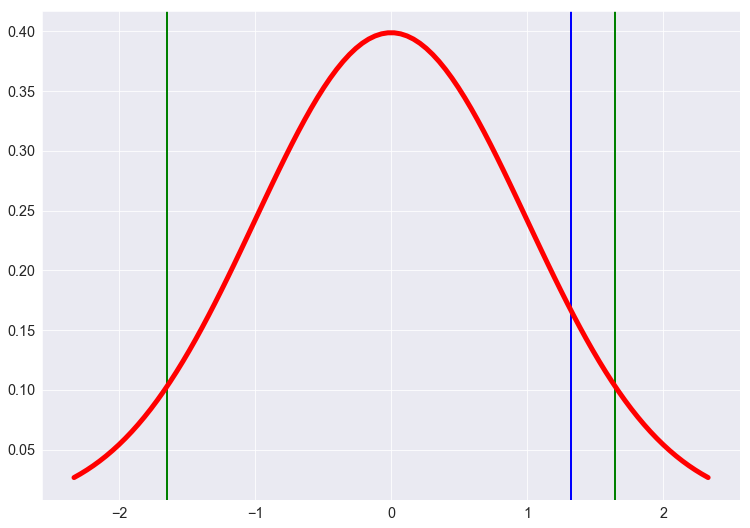

In [232]:
from scipy.stats import norm
from scipy.stats import t


#from z table, the area is 0.9066 > 0.05 so null hypothesis 

df = 999

x = np.linspace(t.ppf(0.01, df),
                t.ppf(0.99, df), 100)

plt.axvline(x= observed_t, color = "blue", linewidth = 2, label=f'True Mean: ' + "%.2f" % np.mean(control))

plt.axvline(x= 1.645, color = "green", linewidth = 2, label=f'True Mean: ' + "%.2f" % np.mean(control))

plt.axvline(x= -1.645, color = "green", linewidth = 2, label=f'True Mean: ' + "%.2f" % np.mean(control))

plt.plot(x, t.pdf(x, df),
       'r-', lw=5, label='t pdf')

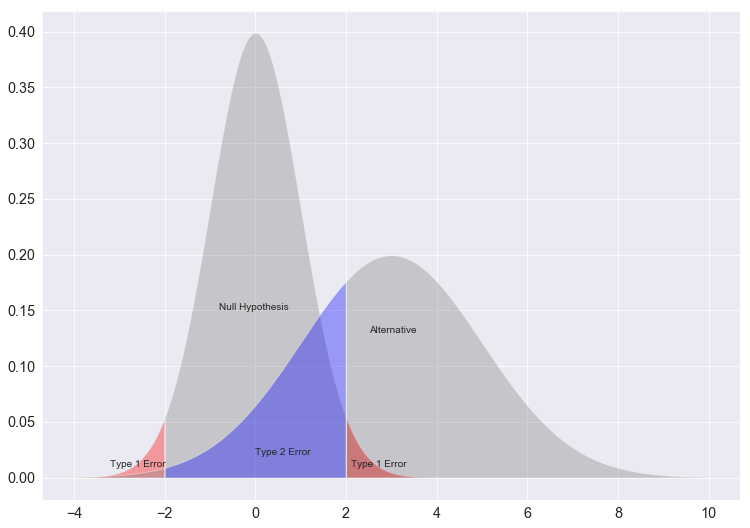

In [230]:
plt.fill_between(x=np.arange(-4,-2,0.01), 
                 y1= stats.norm.pdf(np.arange(-4,-2,0.01)) ,
                 facecolor='red',
                 alpha=0.35)

plt.fill_between(x=np.arange(-2,2,0.01), 
                 y1= stats.norm.pdf(np.arange(-2,2,0.01)) ,
                 facecolor='grey',
                 alpha=0.35)

plt.fill_between(x=np.arange(2,4,0.01), 
                 y1= stats.norm.pdf(np.arange(2,4,0.01)) ,
                 facecolor='red',
                 alpha=0.5)

plt.fill_between(x=np.arange(-4,-2,0.01), 
                 y1= stats.norm.pdf(np.arange(-4,-2,0.01),loc=3, scale=2) ,
                 facecolor='grey',
                 alpha=0.35)

plt.fill_between(x=np.arange(-2,2,0.01), 
                 y1= stats.norm.pdf(np.arange(-2,2,0.01),loc=3, scale=2) ,
                 facecolor='blue',
                 alpha=0.35)

plt.fill_between(x=np.arange(2,10,0.01), 
                 y1= stats.norm.pdf(np.arange(2,10,0.01),loc=3, scale=2),
                 facecolor='grey',
                 alpha=0.35)

plt.text(x=-0.8, y=0.15, s= "Null Hypothesis")
plt.text(x=2.5, y=0.13, s= "Alternative")
plt.text(x=2.1, y=0.01, s= "Type 1 Error")
plt.text(x=-3.2, y=0.01, s= "Type 1 Error")
plt.text(x=0, y=0.02, s= "Type 2 Error");

In [176]:
import pandas as pd 
df = pd.DataFrame()
df['control'] = control
df['treatment'] = treatment

In [177]:
df.control.mean()

74.33112800000093

In [178]:
df.treatment.mean()

75.43929200000098

In [180]:
df.control.std()

14.520859315718848

In [181]:
df.treatment.std()

14.448201566536198

In [182]:
df['difference'] = df['control'] - df['treatment']

In [184]:
df = ()

0      -7.152
1     -32.736
2     -30.984
3      -3.984
4     -21.576
5     -27.108
6     -13.536
7     -12.756
8      14.292
9       7.080
10      0.648
11     21.708
12     11.748
13    -22.164
14    -25.044
15     16.476
16     15.324
17      5.016
18     28.008
19     -9.756
20     23.904
21     -9.000
22     -5.340
23     23.760
24     -1.512
25      2.304
26     26.160
27      8.208
28    -11.580
29     -3.804
        ...  
970     1.008
971   -29.040
972   -18.624
973    36.132
974     5.580
975     7.404
976    38.004
977   -47.064
978    43.452
979    39.372
980     2.328
981    13.416
982    26.976
983    18.048
984   -15.660
985   -14.400
986   -40.068
987   -37.560
988    24.636
989    13.500
990   -36.336
991   -28.728
992   -31.416
993   -30.120
994   -21.192
995    -7.200
996     2.208
997     1.152
998     9.552
999    -8.208
Name: difference, Length: 1000, dtype: float64

# Statistical Power